In [47]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import json

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import helpers
           
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [48]:
#Load zip to fips file, and cast as default dict to avoid error when querying unknown zip
#Sourced from: https://raw.githubusercontent.com/bgruber/zip2fips/master/zip2fips.json
zips2fips = json.load(open('zip2fips-master/zip2fips.json','r')) 
zips2fips = dict(zips2fips) #defaultdict(int,zips2fips)

#Load weather data file
daily_weather_df = pd.read_csv('daily_weather.csv',index_col=0)

/Users/lwa0224/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Initial Data Exploration

With any new data science project, the first step is understanding what the data looks like, including the relevant fields and what a typical record looks like.

## Weather Data

In [49]:
daily_weather_df.head()

adm2_code  year        date  doy  met_avg_t   met_gdd  met_max_rh  \
0   US01031  2003  2003-01-01    1  287.44855  4.298554    96.77753   
1   US01031  2003  2003-01-02    2  286.61816  5.022919    87.06785   
2   US01031  2003  2003-01-03    3  277.10223  0.000000    88.82168   
3   US01031  2003  2003-01-04    4  276.73196  0.399628    80.37215   
4   US01031  2003  2003-01-05    5  281.21307  3.454437    76.90567   

   met_max_t  met_max_vpd  met_min_rh  met_min_t  met_p_mm  met_sh  met_sr_wm2  
0  290.97934     0.065858    50.32994  283.91776   2.11461    0.01    95.24413  
1  293.19586     0.303546    43.54264  280.04047   5.42369    0.01   128.97623  
2  282.69534     0.133233    39.98574  271.50910   0.00000    0.01   128.58878  
3  283.94928     0.254415    34.11516  269.51465   0.00000    0.01   145.93400  
4  290.05887     0.445292    35.75980  272.36730   0.00000    0.01   142.67264

In [50]:
print('There are {} records'.format(daily_weather_df.shape[0]))

There are 6983910 records


In [51]:
#Find the dates which the weather file covers
print('First day: {}'.format(daily_weather_df['date'].min()))
print('Last day: {}'.format(daily_weather_df['date'].max()))

First day: 2003-01-01
Last day: 2018-12-31


In [52]:
#Extract list of weather feature names
weather_features = [c for c in daily_weather_df.columns if c.startswith('met')]
print('{} weather features per day\n'.format(len(weather_features)))
print(', '.join(weather_features))

10 weather features per day

met_avg_t, met_gdd, met_max_rh, met_max_t, met_max_vpd, met_min_rh, met_min_t, met_p_mm, met_sh, met_sr_wm2


Below I plot CDFs of the range of values for each weather features. The vertical dotted lines mark the 5th and 95th percentile. These CDFs give us a sense for the range and variance of the value for each feature as well as the number and extremeness of any outlying values. 

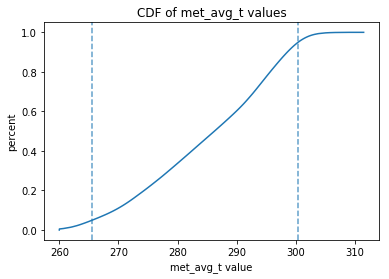

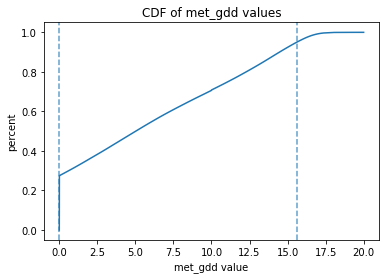

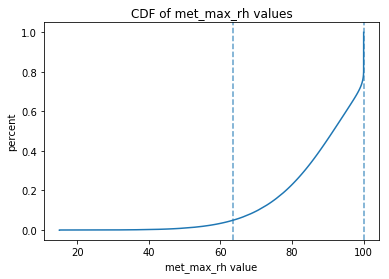

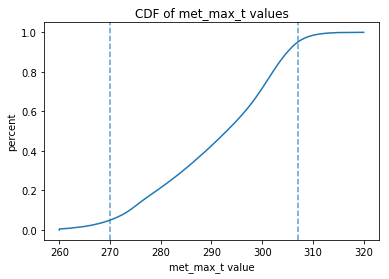

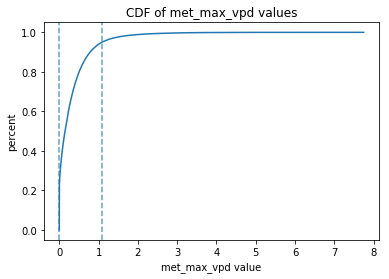

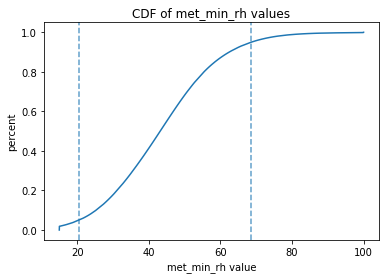

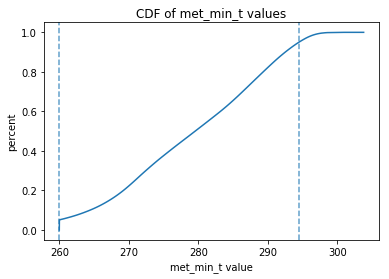

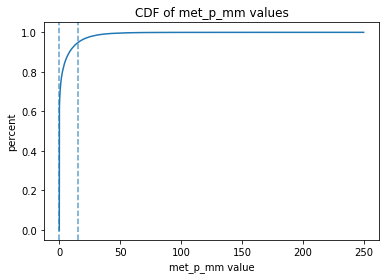

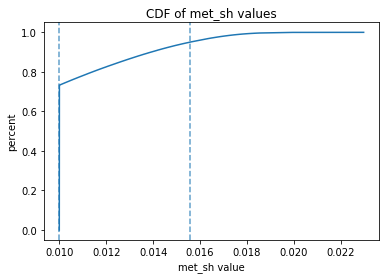

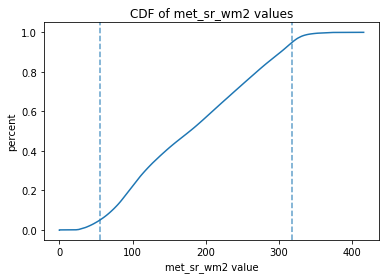

In [53]:
for weather_feature in weather_features:
    helpers.plot_weather_feature_values(weather_feature, daily_weather_df )
    plt.show()

## Wheat Data

In [54]:
#Now let's look at the wheat data
wheat_2014_df = pd.read_csv('gpal/2014-Survey Data-Wheat .csv')
wheat_2015_df = pd.read_csv('gpal/2015-Survey Data-Wheat .csv')
wheat_2016_df = pd.read_csv('gpal/2016 Survey Data-Wheat .csv')

In [55]:
wheat_2014_df.head()

year                           area  zip_code  moisture  kernel_weight  \
0  2014  Area 01 - North Central Texas     76305     13.20          27.20   
1  2014  Area 01 - North Central Texas     76179     13.55          27.83   
2  2014  Area 01 - North Central Texas     76354     13.00          22.48   
3  2014  Area 01 - North Central Texas     76371     11.55          25.57   
4  2014  Area 01 - North Central Texas     79553     11.30          25.57   

   actual_wheat_ash  falling_no  protein_12  
0            0.0400         407   12.581567  
1            0.0408         445   12.388201  
2            0.0431         371   14.150805  
3            0.0522         334   14.336687  
4            0.0411         175   13.899436

In [56]:
wheat_2015_df.head()

year                           area  zip_code  moisture  kernel_weight  \
0  2015.0  Area 01 - North Central Texas   76305.0     11.40          27.14   
1  2015.0  Area 01 - North Central Texas   76371.0     11.90          27.47   
2  2015.0  Area 01 - North Central Texas   76370.0     12.90          23.25   
3  2015.0  Area 01 - North Central Texas   76374.0     11.75          27.64   
4  2015.0  Area 01 - North Central Texas   79553.0     12.00          31.20   

   actual_wheat_ash  falling_no  protein_12  
0            0.0426       361.0   11.451919  
1            0.0454       356.0   11.856527  
2            0.0464       372.0   10.527669  
3            0.0476       330.0   10.998754  
4            0.0446       329.0   12.270000

In [57]:
wheat_2016_df.head()

year                           area  zip_code  moisture  kernel_weight  \
0  2016.0  Area 01 - North Central Texas   76371.0     11.80          29.90   
1  2016.0  Area 01 - North Central Texas   79521.0     11.60          30.26   
2  2016.0  Area 01 - North Central Texas   79553.0     11.80          33.93   
3  2016.0  Area 01 - North Central Texas   79547.0     11.30          32.96   
4  2016.0  Area 01 - North Central Texas   79529.0     12.05          30.75   

   actual_wheat_ash  falling_no  protein_12  
0            0.0434       362.0   10.565986  
1            0.0418       355.0   11.029864  
2            0.0412       328.0   10.755556  
3            0.0382       354.0   10.278241  
4            0.0400       364.0   10.906197

In [58]:
seen_fips = set(wheat_2014_df['zip_code'].unique())
seen_fips.update(set(wheat_2015_df['zip_code'].unique()))
seen_fips.update(set(wheat_2016_df['zip_code'].unique()))
print('There are {} zip codes represented in the data'.format(len(seen_fips)))               

There are 393 zip codes represented in the data


In [59]:
target_cols = ['protein_12','actual_wheat_ash','falling_no']

The processing step removes rows that we have unknown zip code to fip value, or unknown weather data for that zip code. It also casts the year to int, removes rows that aren't needed for this analysis and removes rows with nan values.

In [60]:
wheat_2014_df = helpers.process_wheat_data(wheat_2014_df)
wheat_2015_df = helpers.process_wheat_data(wheat_2015_df)
wheat_2016_df = helpers.process_wheat_data(wheat_2016_df)

/Users/lwa0224/Desktop/Indigo/helpers.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  wheat_data_df['year'] = wheat_data_df['year'].astype(int)
/Users/lwa0224/Desktop/Indigo/helpers.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  wheat_data_df['fips'] = wheat_data_df['zip_code'].map(lambda xx: convert_zip_to_fips(str(int(xx))))


In [61]:
wheat_2016_df.head()

year  zip_code  protein_12  actual_wheat_ash  falling_no   fips
0  2016   76371.0   10.565986            0.0434       362.0  48275
1  2016   79521.0   11.029864            0.0418       355.0  48207
2  2016   79553.0   10.755556            0.0412       328.0  48253
3  2016   79547.0   10.278241            0.0382       354.0  48207
4  2016   79529.0   10.906197            0.0400       364.0  48275

To get a better sense of the distribution of the values for each of the target features, I plot a CDF as well as a vertical line at the values corresponding to the 5th and 95th percentile of the data. This allows us to see where most of the data lies and what outliers look like and how common they are.

In addition to CDFs I plot each wheather feature vs wheat quality feature. These plots can give a general sense of which wheater is correlated which what wheat quality features, and how.

In [62]:
wheat_df = wheat_2014_df.append(wheat_2015_df).append(wheat_2016_df)

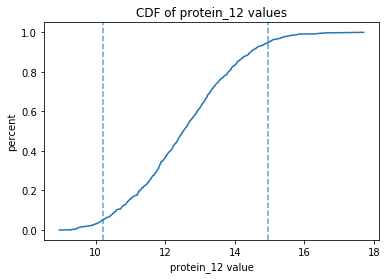

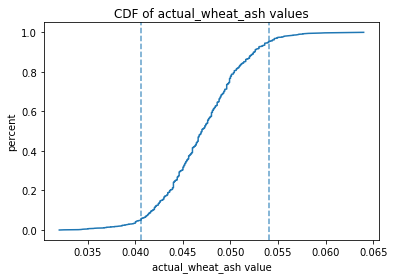

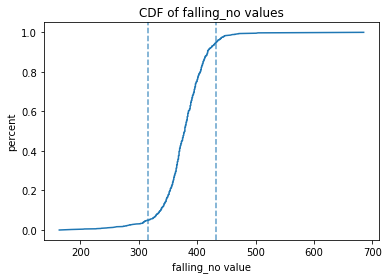

In [63]:
for target_col in target_cols:
    helpers.plot_target_values_cdf(target_col,wheat_df)
    plt.show()

We are interested in understanding the correlation between the weather features and the grain quality features. However, for each grain quality record (year/fips) we have a daily recording for each weather features. This is 10 features per day for a year, or 3650 features. Because there are so many features (many more than samples), I aggregate the wetaher features on a monthly window - so each weather feature gets 12 "readings" (just the average of the 30 readings in the month).

So for example, instead of a daily met_max_t for each fips, I use a monthly met_max_t (so met_max_t_0 is the average for January, met_max_t_2 is the average met_max_t for February etc).

In [64]:
wheat_2014_df = helpers.get_monthly_weather_features(wheat_2014_df,daily_weather_df,2014,weather_features)
wheat_2015_df = helpers.get_monthly_weather_features(wheat_2015_df,daily_weather_df,2015,weather_features)
wheat_2016_df = helpers.get_monthly_weather_features(wheat_2016_df,daily_weather_df,2016,weather_features)

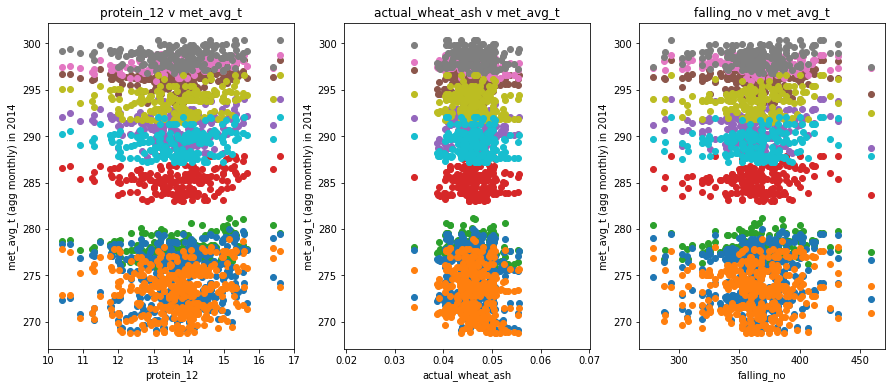

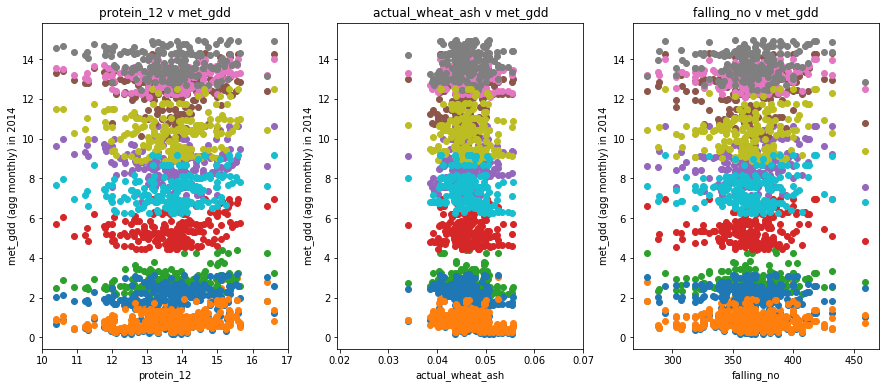

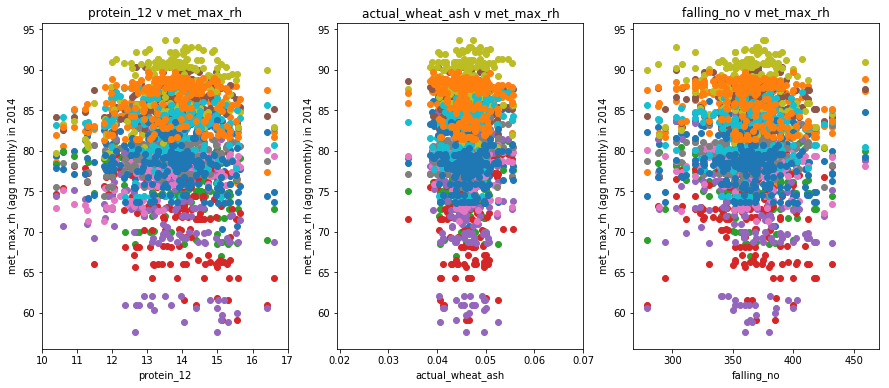

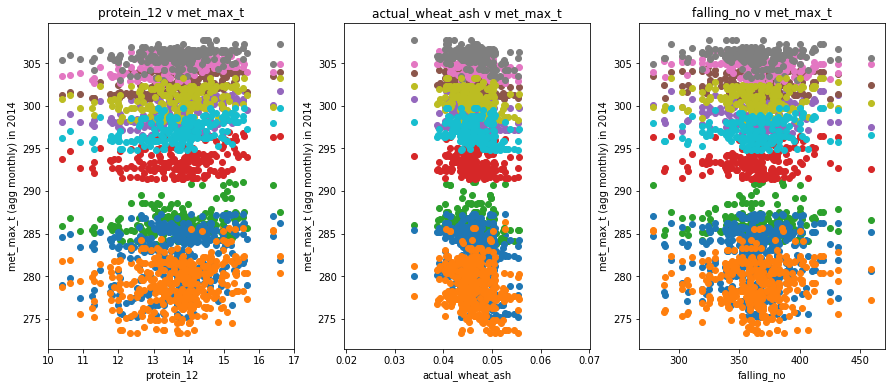

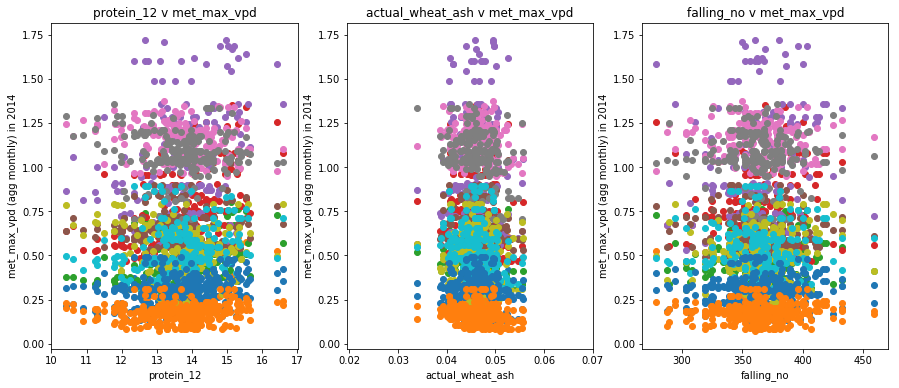

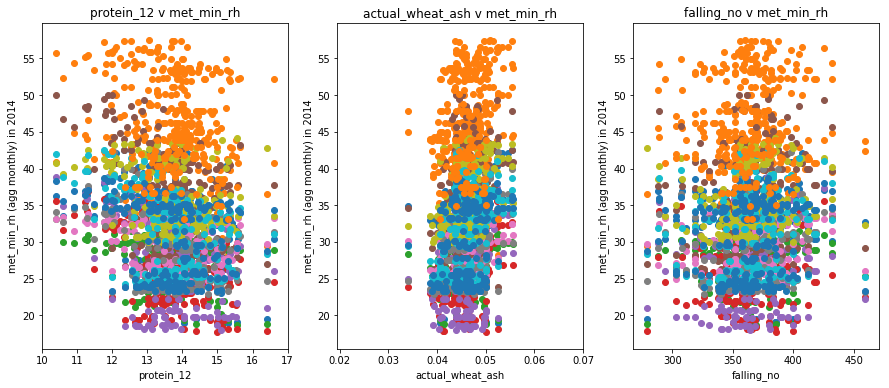

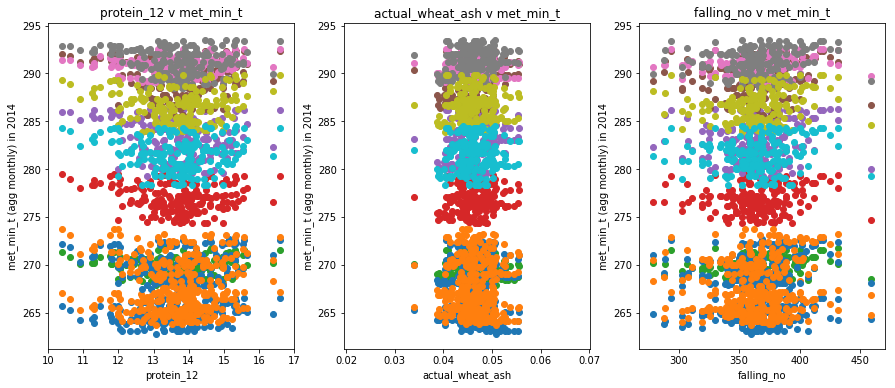

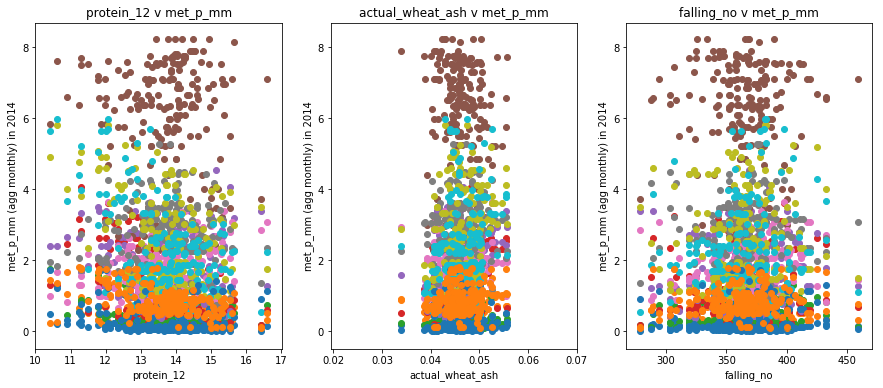

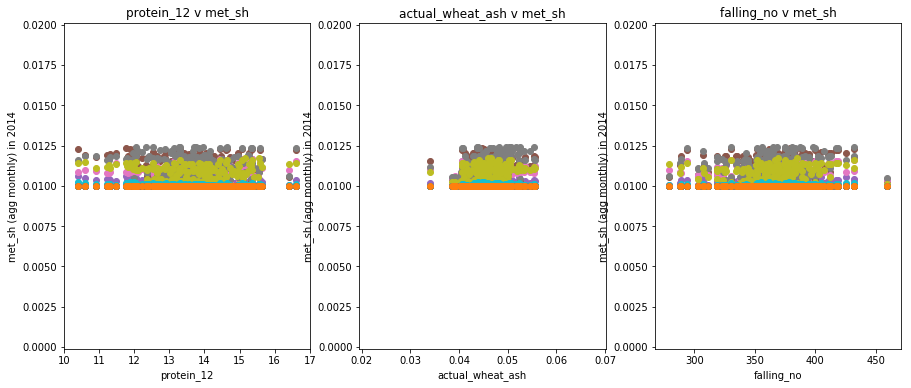

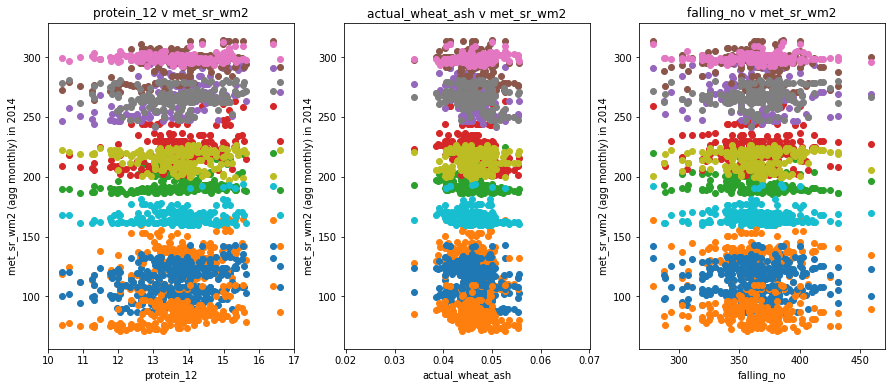

In [65]:
for feat in weather_features:
    feat_cols = [c for c in wheat_2014_df.columns if c.startswith(feat)]
    fig, ax = plt.subplots(1,3,figsize=(15,6))
    for i,target_col in enumerate(target_cols):
        for fc in feat_cols:
            ax[i].scatter(wheat_2014_df[target_col].values, wheat_2014_df[fc].values)
        ax[i].set_title('{} v {}'.format(target_col, feat))
        ax[i].set_xlabel(target_col)
        ax[i].set_ylabel('{} (agg monthly) in {}'.format(feat,2014))        

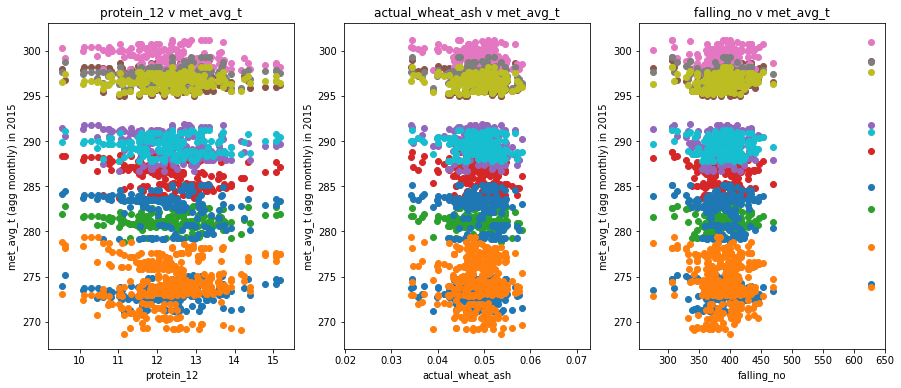

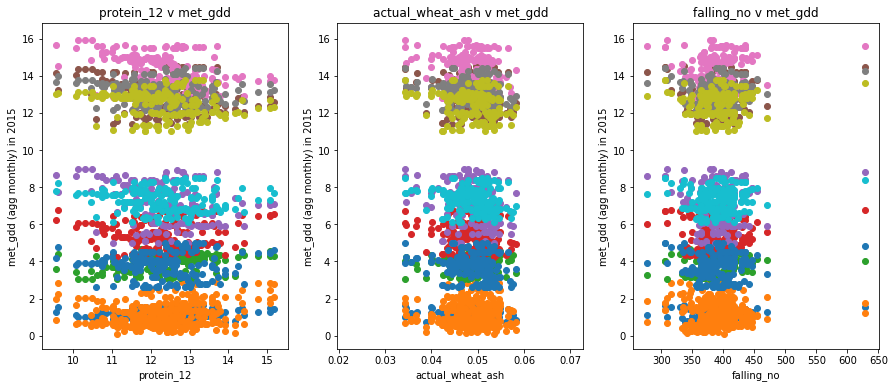

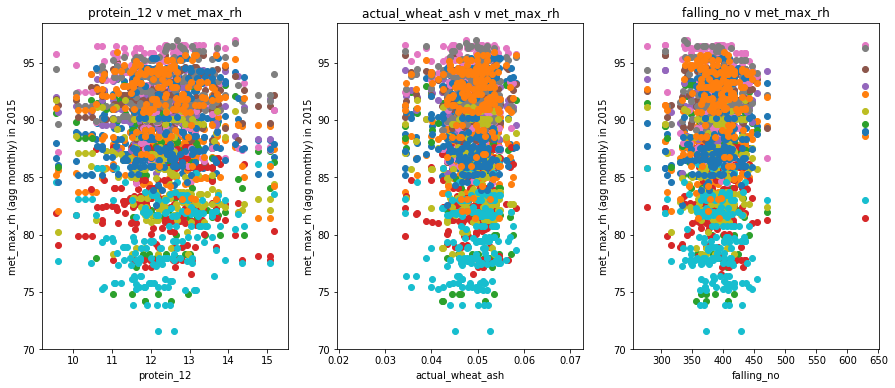

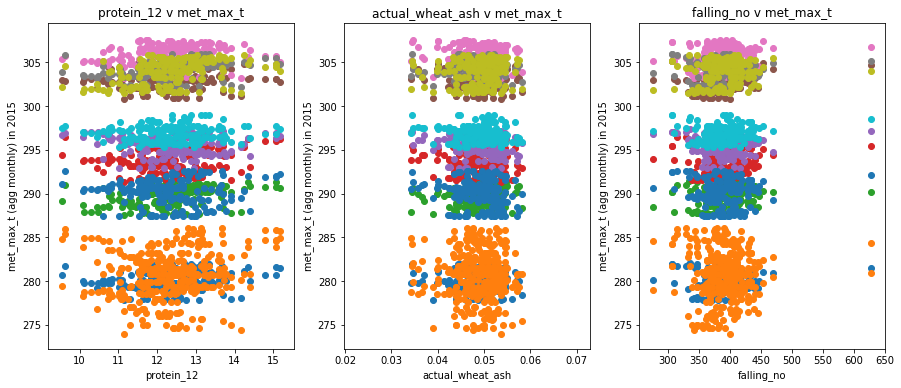

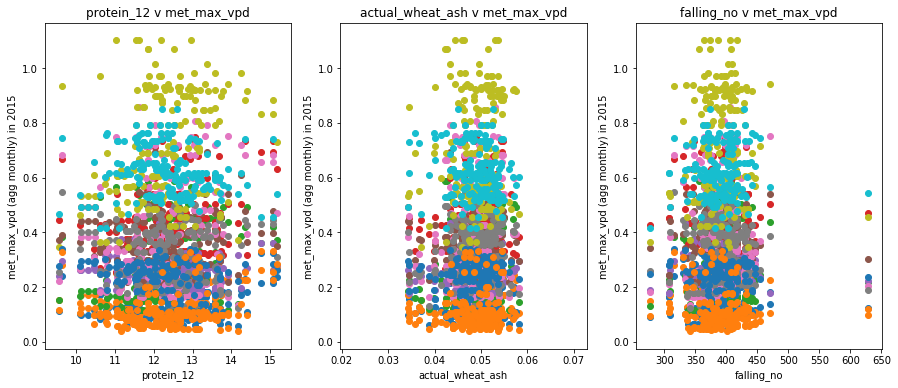

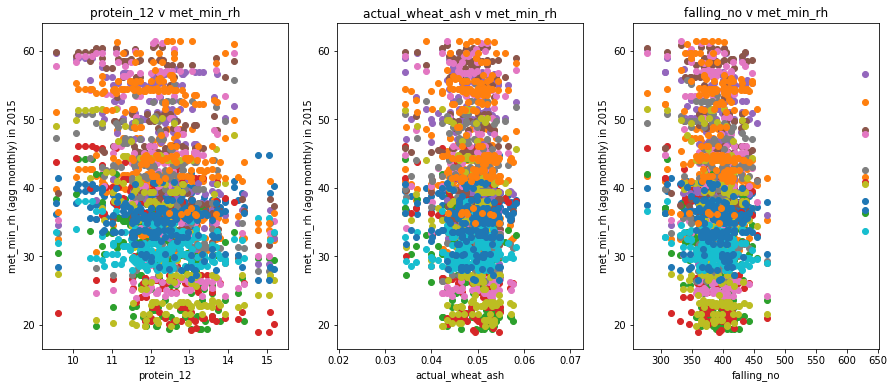

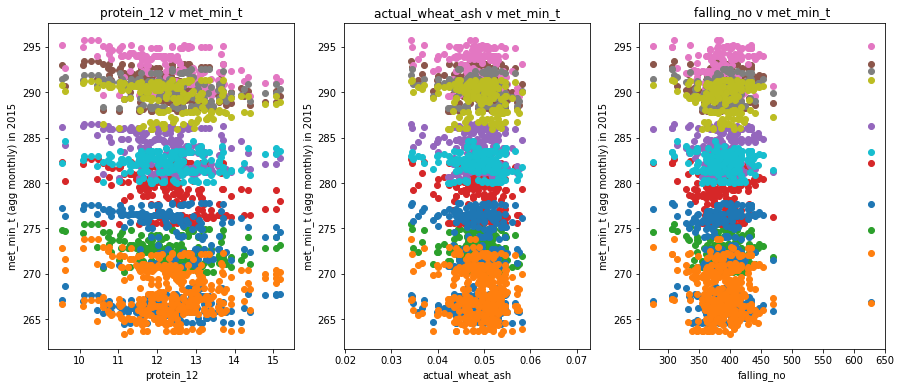

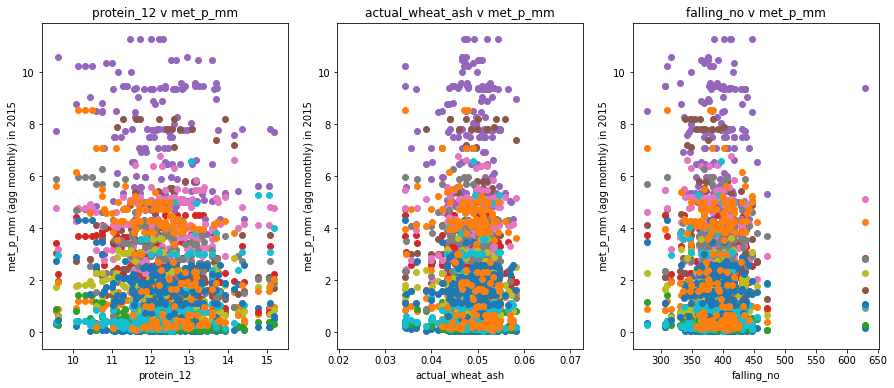

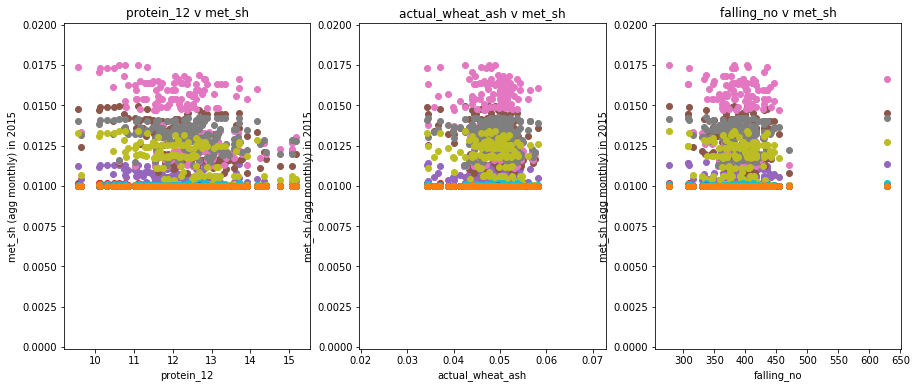

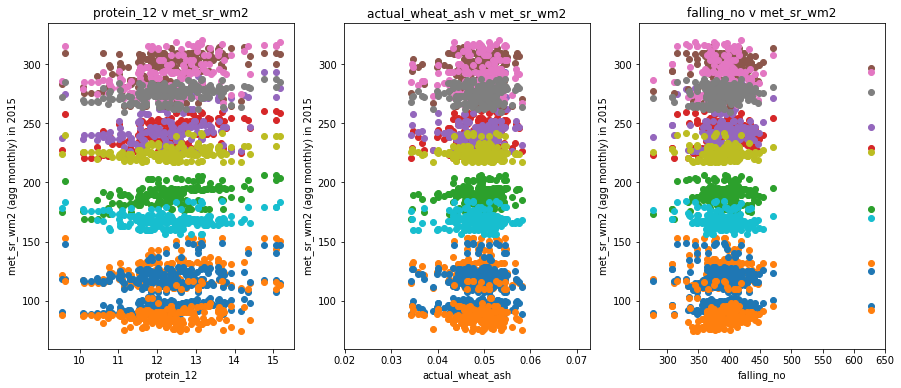

In [66]:
for feat in weather_features:
    feat_cols = [c for c in wheat_2015_df.columns if c.startswith(feat)]
    fig, ax = plt.subplots(1,3,figsize=(15,6))
    for i,target_col in enumerate(target_cols):
        for fc in feat_cols:
            ax[i].scatter(wheat_2015_df[target_col].values, wheat_2015_df[fc].values)
        ax[i].set_title('{} v {}'.format(target_col, feat))
        ax[i].set_xlabel(target_col)
        ax[i].set_ylabel('{} (agg monthly) in {}'.format(feat,2015))        

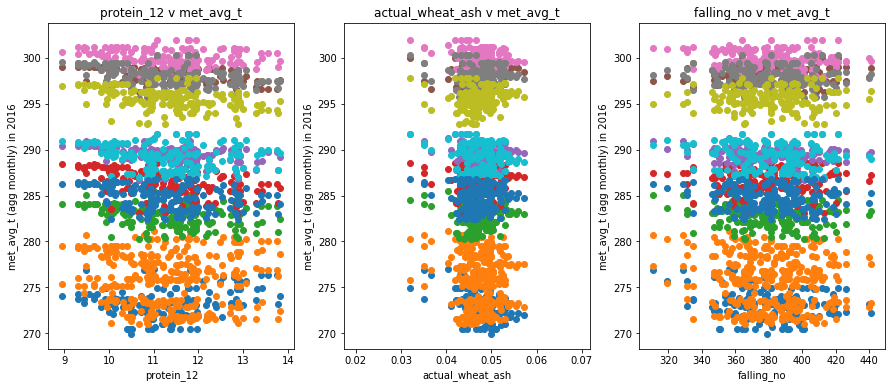

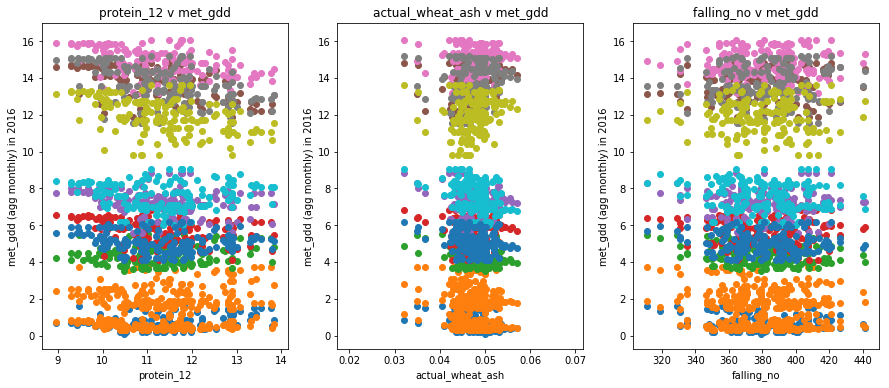

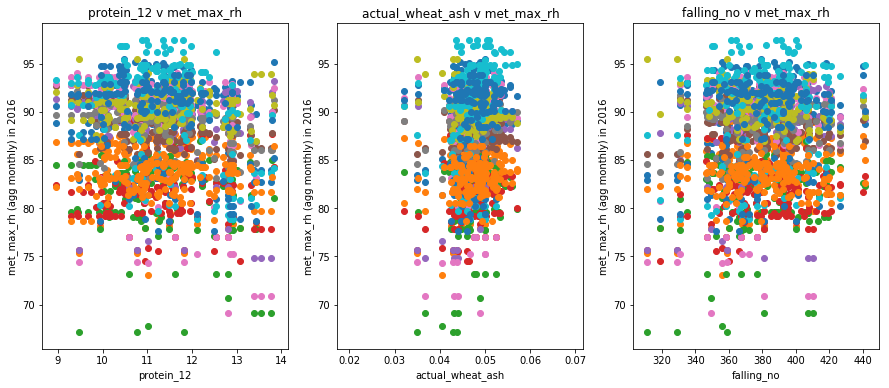

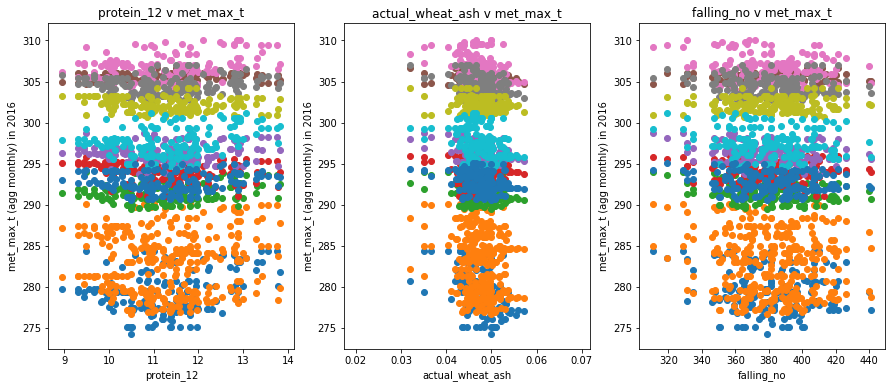

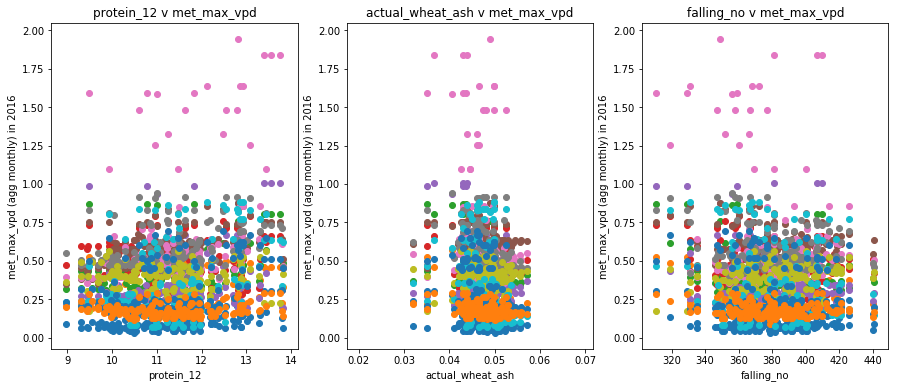

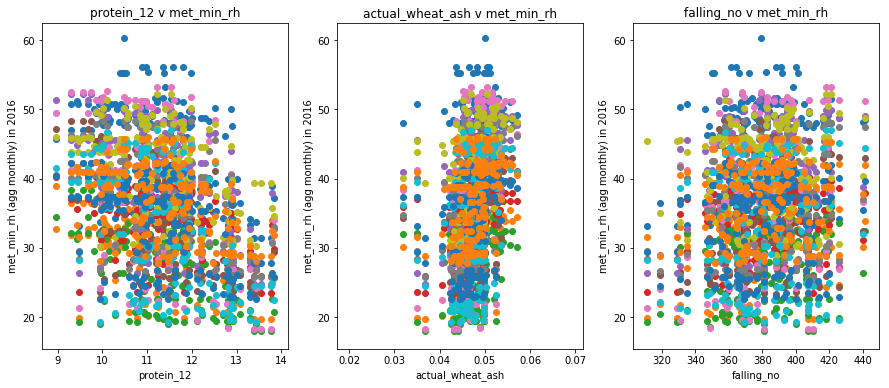

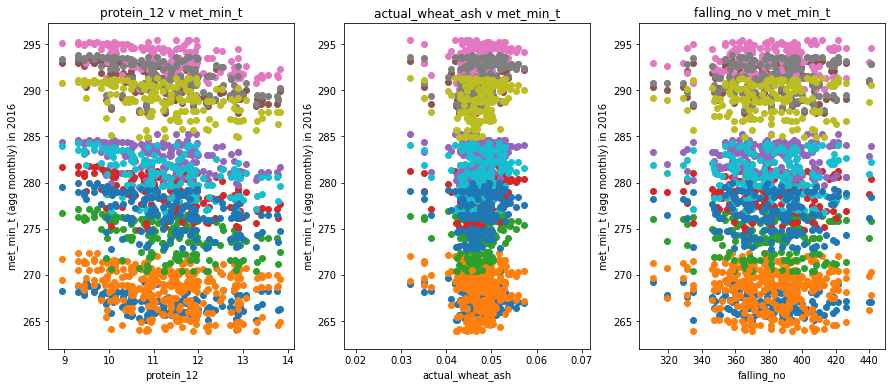

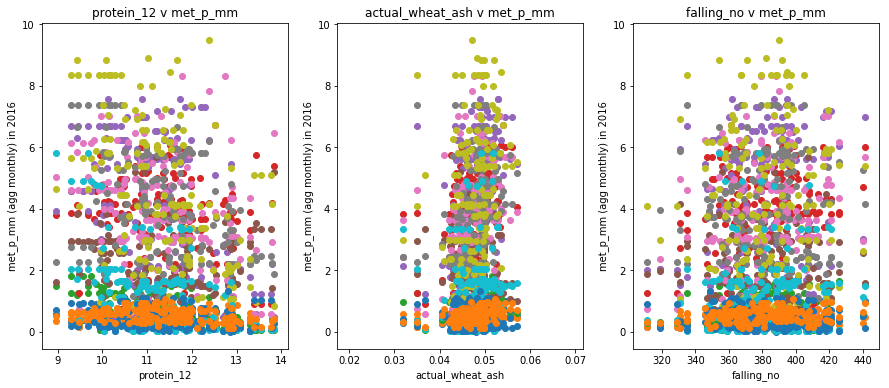

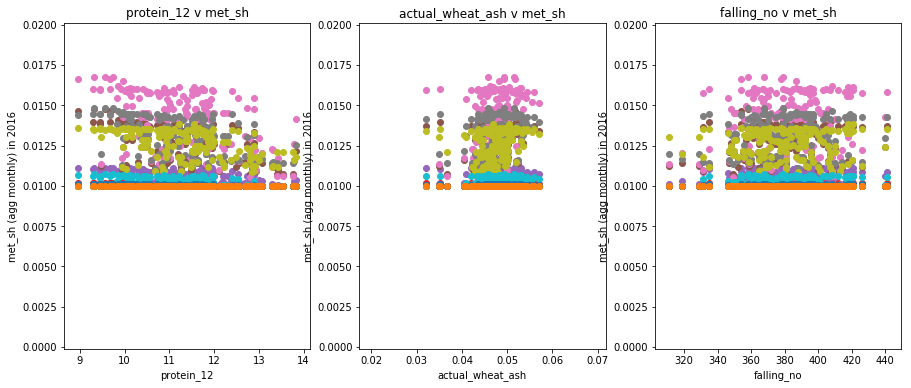

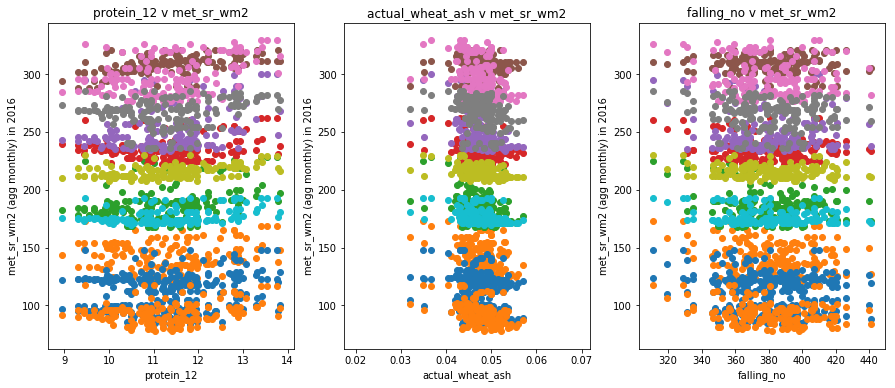

In [67]:
for feat in weather_features:
    feat_cols = [c for c in wheat_2016_df.columns if c.startswith(feat)]
    fig, ax = plt.subplots(1,3,figsize=(15,6))
    for i,target_col in enumerate(target_cols):
        for fc in feat_cols:
            ax[i].scatter(wheat_2016_df[target_col].values, wheat_2016_df[fc].values)
        ax[i].set_title('{} v {}'.format(target_col, feat))
        ax[i].set_xlabel(target_col)
        ax[i].set_ylabel('{} (agg monthly) in {}'.format(feat,2016))        

No weather feature is obviously highly correlated with any grain quality feature. However, often these relationships are complex. 

The next step is do apply a modelling technique to extract the most important features. I'll use linear regression and a random forest. 

Linear regression is usually a good place to start because it is simple and well understood. The coefficients of the features correspond to the "most important features". I also try using a random forest. 

# Linear Regression

First, collect the sample values and the features. I also scale the features to have mean 0 and variance 1 to reduce the effect of weather features with highly different magnitudes. While this isn't strictly necessary for linear regression, it is good for lasso and other machine learning methods.

In [68]:
feat_cols = []
for feat in weather_features:
    feat_cols.extend([c for c in wheat_2014_df.columns if c.startswith(feat)])


year = 2014
target_col = 'protein_12'
wheat_2014_df = wheat_2014_df.dropna()
x = wheat_2014_df[feat_cols].values
y = wheat_2014_df['protein_12'].values

y = np.asarray(y)
x = np.asarray(x)
x_scaled = StandardScaler().fit_transform(x)

In [69]:
model = LinearRegression()
model.fit(x_scaled,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [70]:
print('{} samples, {} features'.format(x_scaled.shape[0], x_scaled.shape[1]))

194 samples, 120 features


It is better to have a lot more samples than features, so I'm going to aggregate the 2014, 2015 and 2016 data

In [71]:
wheat_df = wheat_2014_df.append(wheat_2015_df).append(wheat_2016_df)
wheat_df = wheat_df.dropna()

In [72]:
feat_cols = []
for feat in weather_features:
    feat_cols.extend([c for c in wheat_2014_df.columns if c.startswith(feat)])


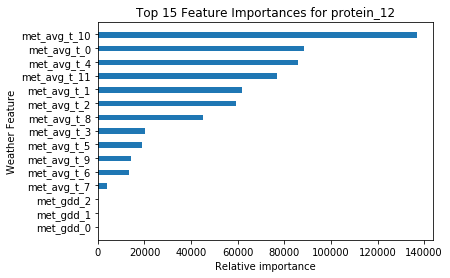

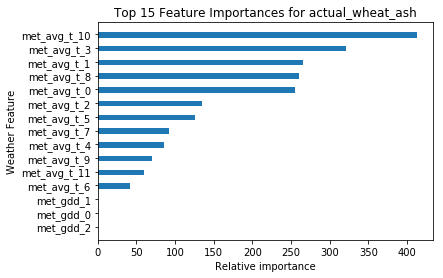

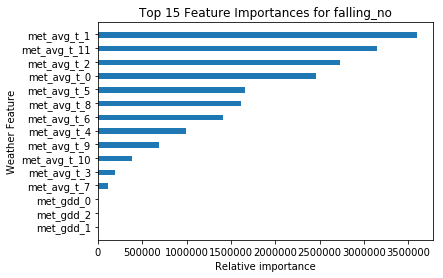

In [73]:
for target_col in target_cols:
    x = wheat_df[feat_cols].values
    y = wheat_df[target_col].values

    y = np.asarray(y)
    x = np.asarray(x)
    #Scale data to mean 0 and variance 1
    x_scaled = StandardScaler().fit_transform(x)
    #Linear regression
    model = LinearRegression()
    model.fit(x_scaled,y)


    fig, ax = plt.subplots() 
    abs_coef = np.abs(model.coef_[:N])
    N = 15
    ind = np.arange(N) 
    ax.barh(ind, sorted(abs_coef), width)
    ax.set_yticks(ind+width/10)
    labels = [feat_cols[i] for i in np.argsort(abs_coef)]
    ax.set_yticklabels(labels) 
    plt.title('Top {} Feature Importances for {}'.format(N,target_col))
    plt.xlabel('Relative importance')
    plt.ylabel('Weather Feature') 


This is telling us that the tempurate has the highest effect on all three target features.

# Random Forest

From the plots I made above, it seems like the relationships between the weather features and the grain quality features are not linear. Random forest is a simple model that can find non-linear relationships in data. It also has the benefit of learning the most important features.

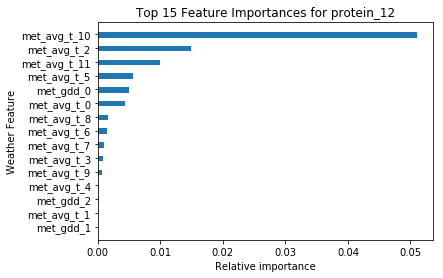

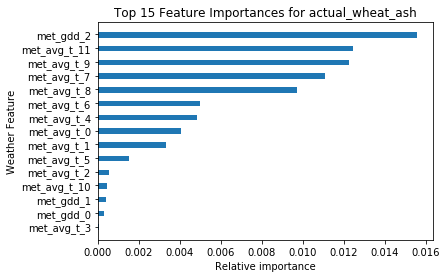

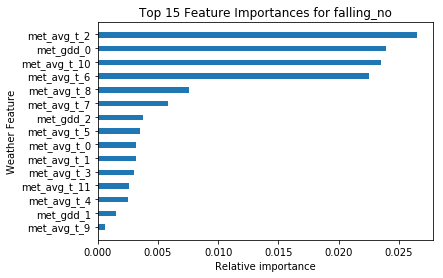

In [74]:
for target_col in target_cols:
    x = wheat_df[feat_cols].values
    y = wheat_df[target_col].values

    y = np.asarray(y)
    x = np.asarray(x)

    model = RandomForestRegressor()
    model.fit(x,y)

    fig, ax = plt.subplots() 
    N = 15
    ind = np.arange(N) 
    ax.barh(ind, sorted(model.feature_importances_[:N]), width)
    ax.set_yticks(ind+width/10)
    labels = [feat_cols[i] for i in np.argsort(model.feature_importances_[:N])]
    ax.set_yticklabels(labels) 
    plt.title('Top {} Feature Importances for {}'.format(N,target_col))
    plt.xlabel('Relative importance')
    plt.ylabel('Weather Feature') 


# Notes

With more time:

1. I would do a more thorough exploration of the data. For example: How many nan values do we have? Which zip codes have the most and the least data? Where do the outliers occur?

2. I would also do a gridsearch over the parameters of the linear regression and random forest models to find the best parameters. This would require some sort of cross-validation too.

3. Explore other features. In this exercise, the features I used were the weather features for the year of the grain data aggregated by month. I would want to try the features aggregated by week or season. I imagine that the previous year's data could be important too.

4. Explore binning the continuous wheat quality features into discrete bins (e.g. low, medium, high)
